In [84]:
# Import the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import *

In [85]:
data = pd.read_excel('Assignment 2 Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')

#make the date the index
data.set_index('Date', inplace=True)
data['PCEPI'] = data['PCEPI'] /100 # Male the inflation index with base 1 instead of 100
industries = data.iloc[:,6:].columns
industry_names = industries.tolist()
industry_names

nominal_vars = data[industry_names + ['GDP' , 'M1SL' , 'M2SL']]

real_vars = pd.DataFrame()

for var in nominal_vars.columns:
    real_vars[var] = nominal_vars[var] / data['PCEPI']

real_vars['PCEPI'] = data['PCEPI']

In [86]:
nan_counts = real_vars.isna().sum()
print(nan_counts)


S5TELS Index      1
S5ENRS Index      1
S5INFT Index      1
S5INDU Index      1
S5FINL Index      1
S5MATR Index      1
S5CONS Index      1
S5COND Index      1
S5HLTH Index      1
S5UTIL Index      1
S5RLST Index    119
SPX Total         1
GDP               2
M1SL              1
M2SL              1
PCEPI             1
dtype: int64


In [87]:
#real_vars = real_vars.loc['2004-01-01':]

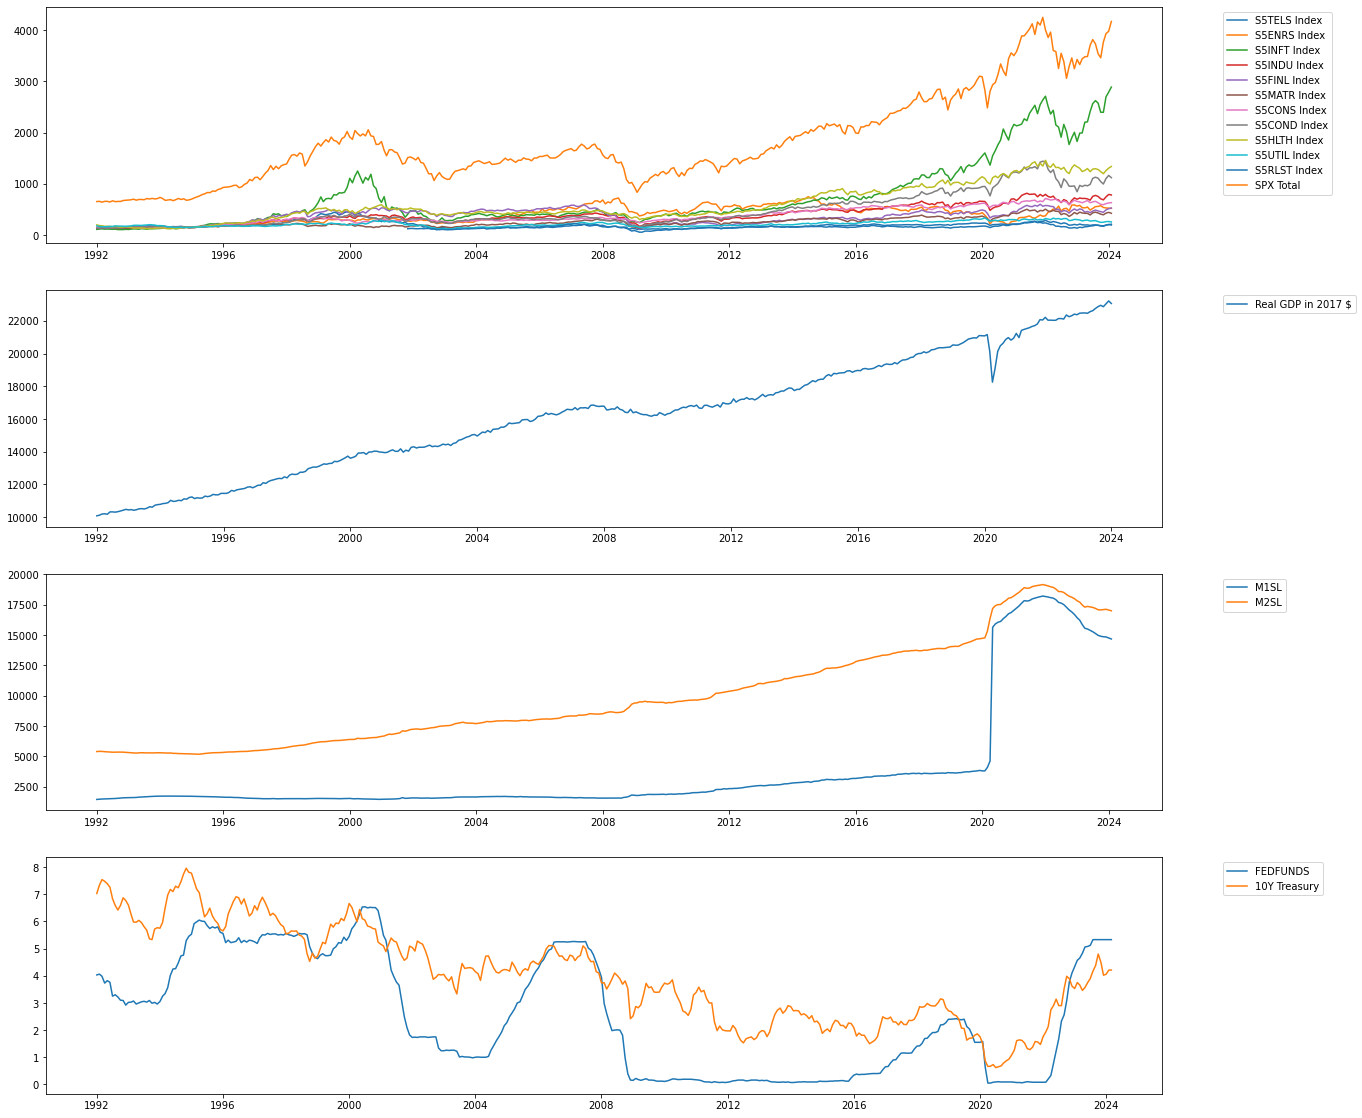

In [88]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(411)
ax.plot(real_vars.index, real_vars[industry_names])
ax.legend(real_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(real_vars.index, real_vars['GDP'])
ax.legend(['Real GDP in 2017 $'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(real_vars.index, real_vars[['M1SL', 'M2SL']])
ax.legend(['M1SL', 'M2SL'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, data[['FEDFUNDS', '10Y Treasury']])
ax.legend(['FEDFUNDS', '10Y Treasury'], bbox_to_anchor=(1.05, 1), loc='upper left')

We perform A standard ADF test on the CPI delated variables. We find that S5MATR Index is stationary when it should not be.
Both interest rates are non-stationary and they should be

In [89]:
for industry in industry_names:
    adfdata = real_vars[industry].dropna()
    result = adfuller(adfdata, regression='ct') #Perform ADF test with constant and trend
    adf_statistic = result[0]
    p_value = result[1]
    print('\n' + industry + ':')
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    if p_value <= 0.05:
        print("This variable is I(0)")
    else:
        print("This variable is I(1)")

adfdata = real_vars['GDP'].dropna()
result_1 = adfuller(adfdata, regression='ct') #Restricted constant and trend
adf_statistic = result_1[0]
p_value = result_1[1]
print('\nReal GDP Growth Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adfdata = real_vars['M1SL'].dropna()
result_2 = adfuller(adfdata, regression='ct') #Restricted constant and trend
adf_statistic = result_2[0]
p_value = result_2[1]
print('\nM1 SUPPLY:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adfdata = real_vars['M2SL'].dropna()
result_3 = adfuller(adfdata, regression='ct') #Restricted constant and trend
adf_statistic = result_3[0]
p_value = result_3[1]
print('\nM2 SUPPLY:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

result_4 = adfuller(data['FEDFUNDS'], regression='c') #Restricted constant but no trend
adf_statistic = result_4[0]
p_value = result_4[1]
print('\nFed Funds Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

result_5 = adfuller(data['10Y Treasury'], regression='c') # 10 year treasury is not stationary
adf_statistic = result_5[0]
p_value = result_5[1]
print('\n10Y Treasury Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")





S5TELS Index:
ADF Statistic: -2.8844706445894808
p-value: 0.16764871392335223
This variable is I(1)

S5ENRS Index:
ADF Statistic: -2.101042994523276
p-value: 0.5455126550551045
This variable is I(1)

S5INFT Index:
ADF Statistic: -0.1310152666301041
p-value: 0.9926348802020089
This variable is I(1)

S5INDU Index:
ADF Statistic: -2.478274911159566
p-value: 0.3389077935439907
This variable is I(1)

S5FINL Index:
ADF Statistic: -2.1871294059816675
p-value: 0.49709692884983
This variable is I(1)

S5MATR Index:
ADF Statistic: -3.526616252181935
p-value: 0.036627872646336615
This variable is I(0)

S5CONS Index:
ADF Statistic: -1.8094316911932387
p-value: 0.7001927722683288
This variable is I(1)

S5COND Index:
ADF Statistic: -1.7866150174942423
p-value: 0.7111763380160355
This variable is I(1)

S5HLTH Index:
ADF Statistic: -1.2804806823123434
p-value: 0.8926719063987306
This variable is I(1)

S5UTIL Index:
ADF Statistic: -3.2310074895014
p-value: 0.07839825124352054
This variable is I(1)

S5R

Given the previous results, we implement Newey West standard errors to account for the heteroskedasticty of the error terms. All variables become non-stationary.

In [90]:
# Define a function to calculate Newey-West standard errors
def newey_west(x, maxlag):
    n = len(x)
    x_mean = np.mean(x)
    s = np.zeros(maxlag+1)
    for i in range(maxlag+1):
        s[i] = np.sum((x[i:] - x_mean) * (x[:n-i] - x_mean)) / n
    return s

# Perform ADF test with Newey-West standard errors
def adf_test_neweywest_constrend(x):
    results = adfuller(x, regression='ct', autolag='AIC')
    adf_statistic = results[0]
    usedlag = results[2]
    nw_se = newey_west(x, usedlag)
    t_statistic = adf_statistic / np.sqrt(nw_se[0])
    return adf_statistic, p_value, t_statistic

# Perform ADF test with Newey-West standard errors
def adf_test_neweywest_cons(x):
    results = adfuller(x, regression='c', autolag='AIC')
    adf_statistic = results[0]
    usedlag = results[2]
    nw_se = newey_west(x, usedlag)
    t_statistic = adf_statistic / np.sqrt(nw_se[0])
    return adf_statistic, p_value, t_statistic

# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    adfdata = real_vars[industry].dropna()
    adf_statistic, p_value, t_statistic = adf_test_neweywest_constrend(adfdata)
    print('\n' + industry + ':')
    print("ADF Statistic:", adf_statistic)
    print("t-statistic:", t_statistic)
    if -1.96 > t_statistic:
        print("This variable is I(0)")
    else:
        print("This variable is I(1)")

adfdata = real_vars['GDP'].dropna()
adf_statistic, p_value, t_statistic = adf_test_neweywest_constrend(adfdata)
print('\nReal GDP Growth Rate:')
print("ADF Statistic:", adf_statistic)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adfdata = real_vars['M1SL'].dropna()
adf_statistic, p_value, t_statistic = adf_test_neweywest_constrend(adfdata)
print('\nM1 SUPPLY:')
print("ADF Statistic:", adf_statistic)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adfdata = real_vars['M2SL'].dropna()
adf_statistic, p_value, t_statistic = adf_test_neweywest_constrend(adfdata)
print('\nM2 SUPPLY:')
print("ADF Statistic:", adf_statistic)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adf_statistic, p_value, t_statistic = adf_test_neweywest_cons(data['FEDFUNDS'])
print('\nFed Funds Rate:')
print("ADF Statistic:", adf_statistic)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adf_statistic, p_value, t_statistic = adf_test_neweywest_cons(data['10Y Treasury'])
print('\n10Y Treasury Rate:')
print("ADF Statistic:", adf_statistic)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")


S5TELS Index:
ADF Statistic: -2.8844706445894808
t-statistic: -0.04310478219856311
This variable is I(1)

S5ENRS Index:
ADF Statistic: -2.101042994523276
t-statistic: -0.013003336930305925
This variable is I(1)

S5INFT Index:
ADF Statistic: -0.1310152666301041
t-statistic: -0.00020511279140506363
This variable is I(1)

S5INDU Index:
ADF Statistic: -2.478274911159566
t-statistic: -0.014326777465746721
This variable is I(1)

S5FINL Index:
ADF Statistic: -2.1871294059816675
t-statistic: -0.016869612227021234
This variable is I(1)

S5MATR Index:
ADF Statistic: -3.526616252181935
t-statistic: -0.03895780703733261
This variable is I(1)

S5CONS Index:
ADF Statistic: -1.8094316911932387
t-statistic: -0.011548866614593454
This variable is I(1)

S5COND Index:
ADF Statistic: -1.7866150174942423
t-statistic: -0.005654844529372523
This variable is I(1)

S5HLTH Index:
ADF Statistic: -1.2804806823123434
t-statistic: -0.0037036729198113086
This variable is I(1)

S5UTIL Index:
ADF Statistic: -3.231007

Given the shape of the graphs, it seems that there may be a compounding effect going on with the industry indeces. We thus convert them to logs and perform the standard ADF test. With this specification, S5MATR Index, S5UTIL Index and M2 are all stationary.

In [91]:
log_vars = np.log(real_vars)

#Take a log difference of the data
treated_vars = log_vars.copy()
treated_vars[['FEDFUNDS', '10Y Treasury']] = data[['FEDFUNDS', '10Y Treasury']]
treated_vars

,S5TELS Index,S5ENRS Index,S5INFT Index,S5INDU Index,S5FINL Index,S5MATR Index,S5CONS Index,S5COND Index,S5HLTH Index,S5UTIL Index,S5RLST Index,SPX Total,GDP,M1SL,M2SL,PCEPI,FEDFUNDS,10Y Treasury
Date,,,,,,,,,,,,,,,,,,
1992-01-01,4.953396,4.995007,4.706243,4.909154,4.883985,4.870485,5.042097,4.895529,5.291300,5.182271,NaN,6.481024,9.218596,7.281682,8.593784,-0.467798,4.03,7.03
1992-02-01,4.900830,4.940552,4.759551,4.913662,4.863532,4.884224,5.008026,4.914698,5.215226,5.116171,NaN,6.487984,9.222497,7.295273,8.596794,-0.465263,4.06,7.34
1992-03-01,4.868955,4.919051,4.801181,4.935055,4.895446,4.906437,5.004117,4.955299,5.196936,5.091146,NaN,6.463517,9.229563,7.305208,8.595522,-0.462845,3.98,7.54
1992-04-01,4.866014,4.883197,4.747315,4.904093,4.873553,4.908080,4.988977,4.938447,5.141631,5.080503,NaN,6.488186,9.230938,7.310063,8.591591,-0.460148,3.73,7.48
1992-05-01,4.941708,4.978866,4.758143,4.924612,4.882707,4.963616,4.995603,4.943475,5.135006,5.104459,NaN,6.488060,9.228141,7.315912,8.589937,-0.458818,3.82,7.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,5.190330,6.286996,7.780622,6.530901,6.094181,5.977885,6.382556,6.902853,7.087055,5.520240,5.142309,8.233723,10.045067,9.605880,9.746028,0.193064,5.33,4.50
2023-12-01,5.264290,6.269150,7.899171,6.611318,6.194397,6.054114,6.418074,7.003798,7.136810,5.563228,5.256808,8.275744,10.052380,9.605033,9.747724,0.194316,5.33,4.02
2024-01-01,5.307251,6.263466,7.932615,6.673768,6.241829,6.092785,6.438286,7.058983,7.173636,5.576223,5.329681,8.287746,10.045705,9.599324,9.744157,0.198080,5.33,4.06


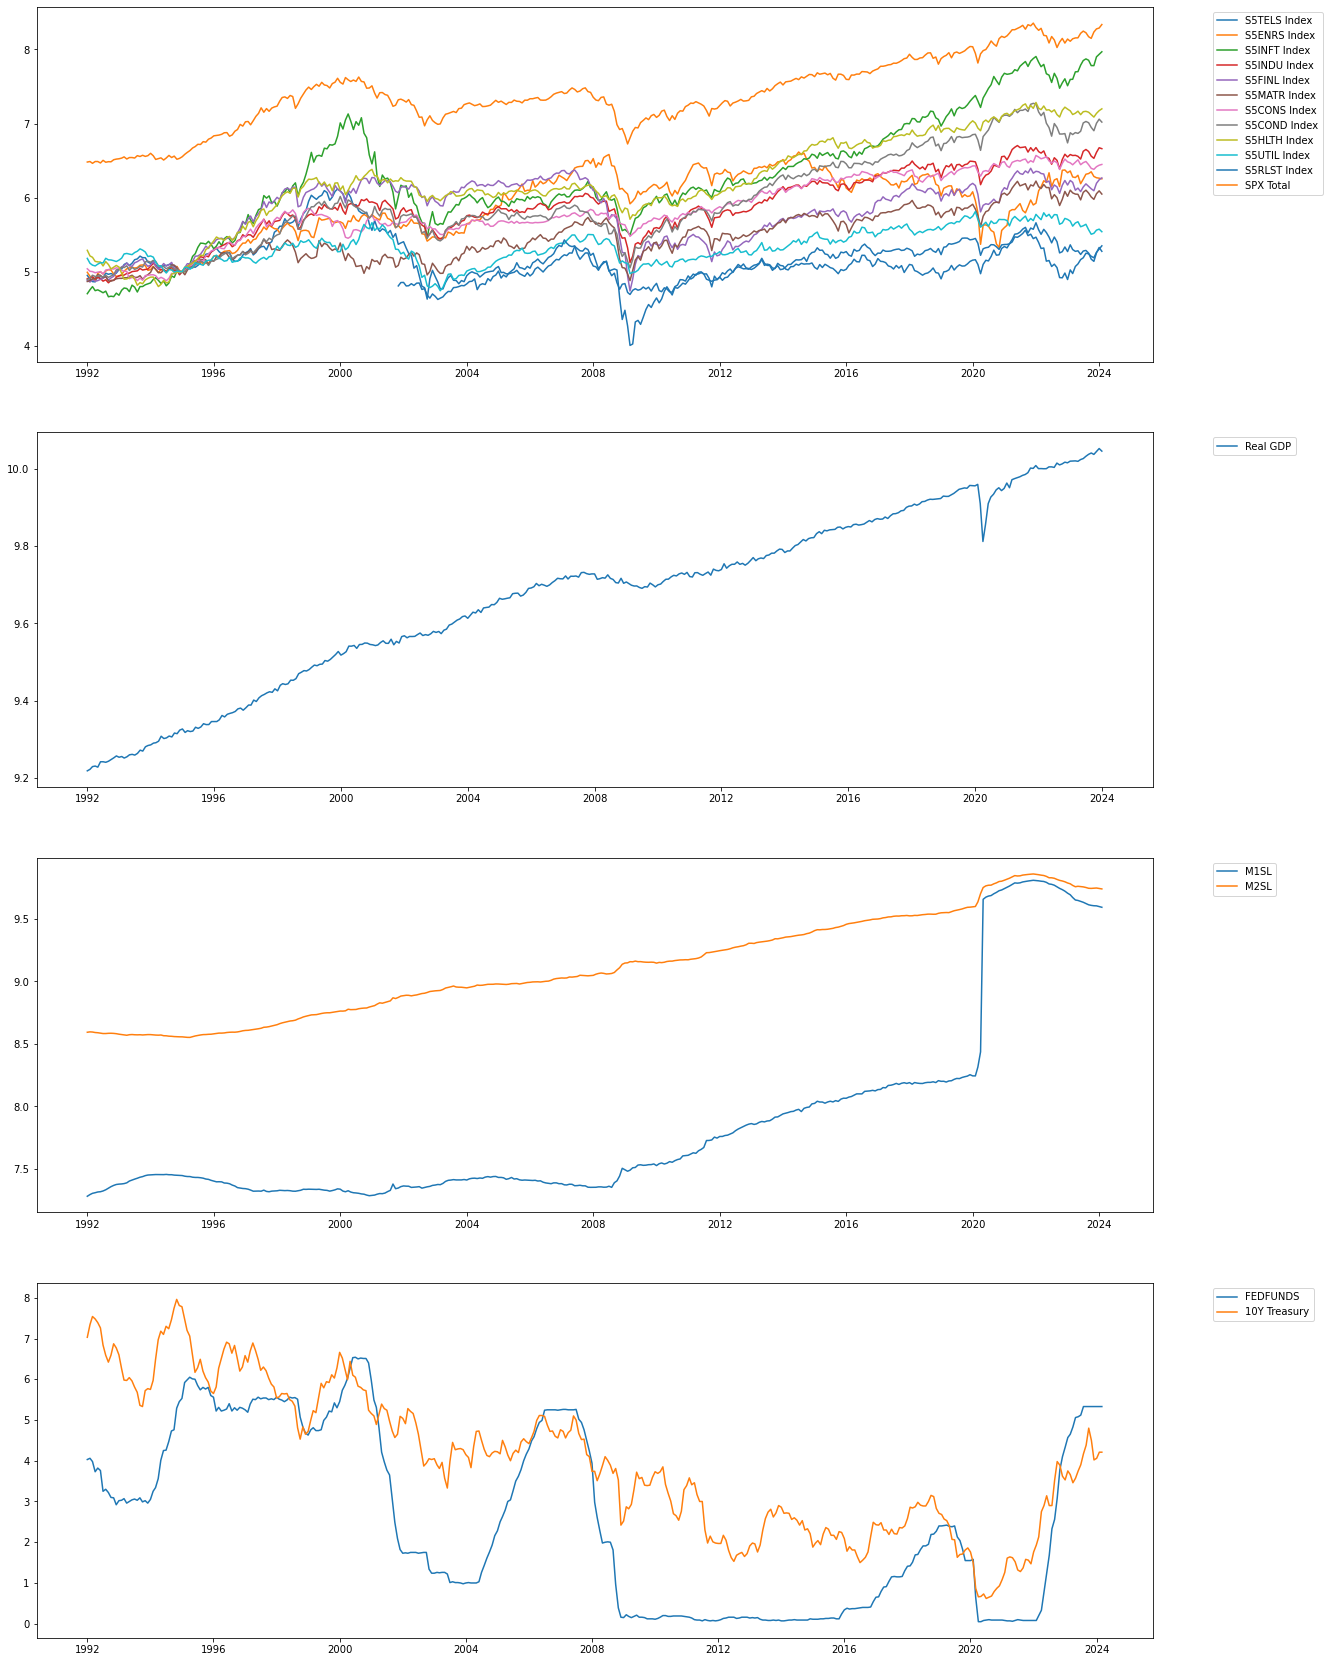

In [92]:
plt.figure(figsize=(20, 30))
ax = plt.subplot(411)
ax.plot(treated_vars.index, treated_vars[industry_names])
ax.legend(treated_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(treated_vars.index, treated_vars[['GDP']])
ax.legend(['Real GDP'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(treated_vars.index, treated_vars[['M1SL', 'M2SL']])
ax.legend(['M1SL', 'M2SL'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, data[['FEDFUNDS', '10Y Treasury']])
ax.legend(['FEDFUNDS', '10Y Treasury'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [93]:
for industry in industry_names:
    adfdata = treated_vars[industry].dropna()
    result = adfuller(adfdata, regression='ct') #Perform ADF test with constant and trend
    adf_statistic = result[0]
    p_value = result[1]
    print('\n' + industry + ':')
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print(len(adfdata))
    if p_value <= 0.05:
        print("This variable is I(0)")
    else:
        print("This variable is I(1)")

adfdata = treated_vars['GDP'].dropna()
result_1 = adfuller(adfdata, regression='ct') #Restricted constant and trend
adf_statistic = result_1[0]
p_value = result_1[1]
print('\nReal GDP Growth Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adfdata = treated_vars['M1SL'].dropna()
result_2 = adfuller(adfdata, regression='ct') #Restricted constant and trend
adf_statistic = result_2[0]
p_value = result_2[1]
print('\nM1 SUPPLY:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adfdata = treated_vars['M2SL'].dropna()
result_3 = adfuller(adfdata, regression='ct') #Restricted constant and trend
adf_statistic = result_3[0]
p_value = result_3[1]
print('\nM2 SUPPLY:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

result_2 = adfuller(data['FEDFUNDS'], regression='c') #Restricted constant but no trend
adf_statistic = result_2[0]
p_value = result_2[1]
print('\nFed Funds Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

result_3 = adfuller(data['10Y Treasury'], regression='c') # 10 year treasury is not stationary
adf_statistic = result_3[0]
p_value = result_3[1]
print('\n10Y Treasury Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
if p_value <= 0.05:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")



S5TELS Index:
ADF Statistic: -3.0526005463798973
p-value: 0.11796350574112985
386
This variable is I(1)

S5ENRS Index:
ADF Statistic: -2.1131308756584453
p-value: 0.5387362437591168
386
This variable is I(1)


Our last ADF test is by using the logged variables and the Newey-West Standard Errors

In [ ]:
# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    adfdata = treated_vars[industry].dropna()
    adf_statistic, p_value, t_statistic = adf_test_neweywest_constrend(adfdata)
    print('\n' + industry + ':')
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("t-statistic:", t_statistic)
    if -1.96 > t_statistic:
        print("This variable is I(0)")
    else:
        print("This variable is I(1)")

adfdata = treated_vars['GDP'].dropna()
adf_statistic, p_value, t_statistic = adf_test_neweywest_constrend(adfdata)
print('\nReal GDP Growth Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adfdata = treated_vars['M1SL'].dropna()
adf_statistic, p_value, t_statistic = adf_test_neweywest_constrend(adfdata)
print('\nM1 SUPPLY:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adfdata = treated_vars['M2SL'].dropna()
adf_statistic, p_value, t_statistic = adf_test_neweywest_constrend(adfdata)
print('\nM2 SUPPLY:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adf_statistic, p_value, t_statistic = adf_test_neweywest_cons(data['FEDFUNDS'])
print('\nFed Funds Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")

adf_statistic, p_value, t_statistic = adf_test_neweywest_cons(data['10Y Treasury'])
print('\n10Y Treasury Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("t-statistic:", t_statistic)
if -1.96 > t_statistic:
    print("This variable is I(0)")
else:
    print("This variable is I(1)")


S5TELS Index:
ADF Statistic: -3.0526005463798973
p-value: 0.20208346962845525
t-statistic: -10.460402395755695
This variable is I(0)

S5ENRS Index:
ADF Statistic: -2.1131308756584453
p-value: 0.20208346962845525
t-statistic: -4.555218335104558
This variable is I(0)

S5INFT Index:
ADF Statistic: -1.4629926157575808
p-value: 0.20208346962845525
t-statistic: -1.8184489491214602
This variable is I(1)

S5INDU Index:
ADF Statistic: -2.490152040645584
p-value: 0.20208346962845525
t-statistic: -5.37506209387846
This variable is I(0)

S5FINL Index:
ADF Statistic: -2.1305866488382748
p-value: 0.20208346962845525
t-statistic: -5.09436848063545
This variable is I(0)

S5MATR Index:
ADF Statistic: -3.9404598732188347
p-value: 0.20208346962845525
t-statistic: -11.402511015434577
This variable is I(0)

S5CONS Index:
ADF Statistic: -2.1647138076225314
p-value: 0.20208346962845525
t-statistic: -4.888685454376485
This variable is I(0)

S5COND Index:
ADF Statistic: -1.9825695872590199
p-value: 0.20208346